<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src= "_data\fig\buildingdamage.svg"
/>
</figure>


<h1 style="width: 60%; color: #EC6842; font-size: 55pt;">
    <Strong>
        IJsselsteinseweg 77
    </Strong>
</h1>

<h2 id="Background"><B>
    Rationale for the project<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     This studies case study is the building IJsselsteinseweg 77 in Nieuwegein in the Netherlands, a deatched 2-layer unreinforced masonry structure from 1961 with 2 floors and a cellar which was eventually demolished circa 2015. We can evaluate the state of damage before its demolishing due to a Foundation research report that was commissioned by the owner to Sandra Lobbe Ispectie & Advies, a building consulting firm who carried out the building and foundation investigation on June 2019 and thereafter produced a report documenting the buildings measurements, characteristics, damage state and their own assessment on the necessary course of action or risk of the building integrity due to subsidence effects. The main assessment found that the current capacity provided by the building’s foundation was Insufficient and given the experienced deformations by the building and the damage state of the building, countermeasures should be implemented in a period of 1-5 years following the assessment date. 
</p>

## <strong> X | Imports</strong>

In [3]:
from bricks import house, LTSM, EM
from bricks.tools import plots

import numpy as np

## <strong> 0 | Instantiate `HOUSE` object</strong>

### <strong> 0.1 | Structure dimensions and measurements</strong>

In [4]:
walls = {
    'Wall 1':{"x": np.array([0, 0, 0]), "y": np.array([0, 3.5, 7]), "z": np.array([0, -72, -152]), 'phi': np.array([1/200,1/200]), 'height': 5250, 'thickness': 27,'area': 390600},
    'Wall 2':{"x": np.array([0, 4.5, 8.9]), "y": np.array([7, 7, 7]), "z": np.array([-152, -163, -188]),  'phi': np.array([1/33,1/50]), 'height': 5250, 'thickness': 27,'area': 464625},
    'Wall 3':{"x": np.array([8.9, 8.9]), "y": np.array([3.6, 7]), "z": np.array([-149, -188]), 'phi': np.array([0,0]), 'height': 5250, 'thickness': 27,'area': 166950},
    'Wall 4':{"x": np.array([8.9, 10.8]), "y": np.array([3.6, 3.6]), "z": np.array([-149,-138]), 'phi': np.array([0,0]), 'height': 2850, 'thickness': 27,'area': 49020},
    'Wall 5':{"x": np.array([10.8, 10.8]), "y": np.array([0, 3.6]), "z": np.array([-104, -138]), 'phi': np.array([1/77,1/67]), 'height': 2850, 'thickness': 27,'area': 96720},
    'Wall 6':{"x": np.array([0, 5.2, 6.4, 8.9, 10.8]), "y": np.array([0, 0, 0, 0, 0]), "z": np.array([0, -42, -55, -75, -104]), 'phi': np.array([1/100,1/100]), 'height': 5000, 'thickness': 27, 'area': 517980},
}

damage =  { 'crack_1' : {'wall_id' : 'wall2','c_w': 4,'c_l': 890,},
            'crack_2' : {'wall_id' : 'wall1','c_w': 2,'c_l': 1670,},
            'crack_3' : {'wall_id' : 'wall2','c_w': 3,'c_l': 1868,},
            'crack_4' : {'wall_id' : 'wall7','c_w': 0.1,'c_l': 2000,},
            'crack_5' : {'wall_id' : 'wall2','c_w': 2,'c_l': 1760,},
            'crack_6' : {'wall_id' : 'wall2','c_w': 1,'c_l': 994,},
            'crack_7' : {'wall_id' : 'wall2','c_w': 0.1,'c_l': 500,},
            'crack_8' : {'wall_id' : 'wall2','c_w': 2,'c_l': 993,}}

ijsselsteinseweg = house(measurements = walls)
ijsselsteinseweg.state = damage

### <strong> 0.2 | Estimating the displacement surface</strong>

In [5]:
ijsselsteinseweg.interpolate() # Interpolate subsidence shape
params = ijsselsteinseweg.soil['house'].values()
# plots.plot_surface(*params)
plots.wall_displacement(ijsselsteinseweg)

AttributeError: 'house' object has no attribute 'boundary'

From the above data we can observe how all curves increasingly progress towards the maximum displacement but do not resemble a gaussian shape which we assume to be the shape that subsidence patterns take. As a consequence we require to try to extrapolate outside the data to conitnuate the subisdence shape and we make use of an optimisation algorithm in order to find the values of the different variables in the function.   

In [15]:
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
from bricks.assessment.utils import gaussian_shape, interpolate_2d 


In [74]:
filtered_tuples = [list(t)[:-1] for t in tuples if t[2] == 0]

In [91]:
import itertools

In [92]:
self = ijsselsteinseweg
vertices = [[self.house[wall]['x'].min() if x else self.house[wall]['x'].max(), 
                            self.house[wall]['y'].min() if y else self.house[wall]['y'].max(), 
                            z] 
                            for wall in self.house
                            for x, y, z in itertools.product([0,10], repeat=3)] + [[0,0,0]] # get all vertices of the walls
vertices = list(set(tuple(vertex) for vertex in vertices))
        

In [93]:
vertices

[(0, 0.0, 10),
 (8.9, 7, 10),
 (8.9, 7, 0),
 (0, 7.0, 10),
 (0, 7.0, 0),
 (0, 0.0, 0),
 (10.8, 3.6, 10),
 (10.8, 3.6, 0),
 (10.8, 0.0, 10),
 (8.9, 3.6, 10),
 (10.8, 0.0, 0),
 (8.9, 3.6, 0)]

In [84]:
hull  = Delaunay(filtered_tuples)
x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)
mesh_points = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
inside_hull = hull.find_simplex(mesh_points) >= 0
inside_hull = inside_hull.reshape(x_mesh.shape)

In [94]:
points

array([[ 0. ,  0. ],
       [ 0. ,  3.5],
       [ 0. ,  7. ],
       [ 0. ,  7. ],
       [ 4.5,  7. ],
       [ 8.9,  7. ],
       [ 8.9,  3.6],
       [ 8.9,  7. ],
       [ 8.9,  3.6],
       [10.8,  3.6],
       [10.8,  0. ],
       [10.8,  3.6],
       [ 0. ,  0. ],
       [ 5.2,  0. ],
       [ 6.4,  0. ],
       [ 8.9,  0. ],
       [10.8,  0. ]])

In [42]:
x_min = min(self.house[wall]["x"].min() for wall in self.house)
x_max = max(self.house[wall]["x"].max() for wall in self.house)
y_min = min(self.house[wall]["y"].min() for wall in self.house)
y_max = max(self.house[wall]["y"].max() for wall in self.house)

# -------------------------------- create mesh ------------------------------- #
x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
x_boundary, y_boundary, z_boundary = self.boundary
points = np.column_stack((x_boundary, y_boundary))
hull = Delaunay(points)
x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)
mesh_points = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
inside_hull = hull.find_simplex(mesh_points) >= 0
inside_hull = inside_hull.reshape(x_mesh.shape)
# ---------------------------- Interpolate surface --------------------------- #
z_lin = interpolate_2d(x_boundary, y_boundary, z_boundary, x_mesh, y_mesh, 'linear')
z_qint = interpolate_2d(x_boundary, y_boundary, z_boundary, x_mesh, y_mesh, 'cubic')

z_lin[~inside_hull] = np.nan
z_qint[~inside_hull] = np.nan
# ------------------------------- Process walls ------------------------------ #


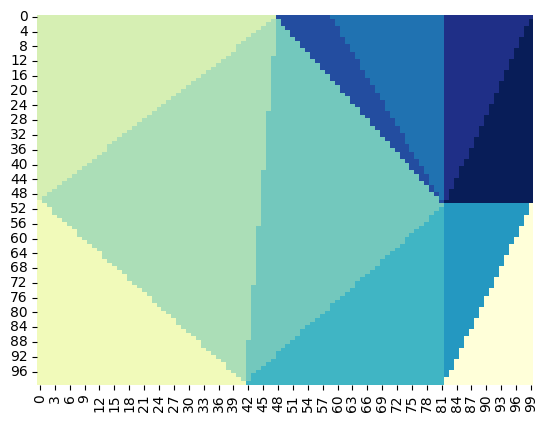

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
sns.heatmap(rr, cmap="YlGnBu", cbar=False)

# Display the plot
plt.show(block = True)

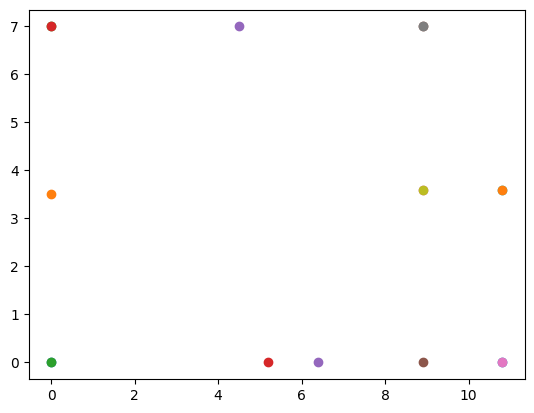

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure()
for x,y in points:
    plt.scatter(x,y)

In [18]:
self.process['int'] = {}
for wall in ['Wall 1']:
    x_start, x_end = self.house[wall]['x'][0], self.house[wall]['x'][-1]
    y_start, y_end = self.house[wall]['y'][0], self.house[wall]['y'][-1]

    x_start_idx = np.argmin(np.abs(x_lin - x_start))
    x_end_idx = np.argmin(np.abs(x_lin - x_end)) + 1  
    y_start_idx = np.argmin(np.abs(y_lin - y_start))
    y_end_idx = np.argmin(np.abs(y_lin - y_end)) + 1

    if np.all(self.house[wall]['x'] == self.house[wall]['x'][0]):  # wall is along the y axis
            z_lin_slice = z_lin[x_start_idx:x_end_idx, y_start_idx:y_end_idx].flatten()
            z_qint_slice = z_qint[x_start_idx:x_end_idx, y_start_idx:y_end_idx].flatten()
            ax = y_lin[y_start_idx:y_end_idx]
            ax_rel = ax - y_lin[y_start_idx]   
            self.process['int'][wall] = {'z_lin': z_lin_slice,
                                            'z_q': z_qint_slice,
                                            'ax': ax,
                                            'ax_rel': ax_rel}
    else:  # wall is along the x axis
        z_lin_slice = z_lin[x_start_idx:x_end_idx, y_start_idx:y_end_idx].flatten()
        z_qint_slice = z_qint[x_start_idx:x_end_idx, y_start_idx:y_end_idx].flatten()
        ax = x_lin[x_start_idx:x_end_idx]
        ax_rel = ax - x_lin[x_start_idx]
        self.process['int'][wall] = {'z_lin': z_lin_slice,
                                        'z_q': z_qint_slice,
                                        'ax': ax,
                                        'ax_rel': ax_rel}

In [21]:
y_end_idx

100

### <strong> 0.3 | Estimating the greenfield soil profile for the building</strong>


In [20]:
min(y_normal)

-104.0

In [5]:
ijsselsteinseweg.house['Wall 1']['z']

array([   0,  -72, -152])

In [8]:
ijsselsteinseweg.process['int'][wall]["z_lin"]

array([   0.        ,   -0.88111888,   -1.76223776,   -2.64335664,
         -3.52447552,   -4.40559441,   -5.28671329,   -6.16783217,
         -7.04895105,   -7.93006993,   -8.81118881,   -9.69230769,
        -10.57342657,  -11.45454545,  -12.33566434,  -13.21678322,
        -14.0979021 ,  -14.97902098,  -15.86013986,  -16.74125874,
        -17.62237762,  -18.5034965 ,  -19.38461538,  -20.26573427,
        -21.14685315,  -22.02797203,  -22.90909091,  -23.79020979,
        -24.67132867,  -25.55244755,  -26.43356643,  -27.31468531,
        -28.1958042 ,  -29.07692308,  -29.95804196,  -30.83916084,
        -31.72027972,  -32.6013986 ,  -33.48251748,  -34.36363636,
        -35.24475524,  -36.12587413,  -37.00699301,  -37.88811189,
        -38.76923077,  -39.65034965,  -40.53146853,  -41.41258741,
        -42.39393939,  -43.57575758,  -44.75757576,  -45.93939394,
        -47.12121212,  -48.3030303 ,  -49.48484848,  -50.66666667,
        -51.84848485,  -53.03030303,  -54.21212121,  -55.29090

In [7]:
from scipy.optimize import curve_fit
function = curve_fit
self = ijsselsteinseweg
wall = 'Wall 1'

x_data = self.process['int'][wall]["ax"]
x_data_rel = self.process['int'][wall]["ax_rel"]
y_data = self.process['int'][wall]["z_lin"]

# Drop nan values
mask = np.isnan(y_data)
x_data = x_data[~mask]
y_data = y_data[~mask]

index = np.argmin(y_data)
y_normal = np.concatenate((y_data[:index + 1], y_data[:index][::-1]))
x_gauss = np.concatenate((-x_data_rel[:index + 1][::-1], x_data_rel[:index]))
x_data = np.concatenate((x_data[:index + 1], x_data[index] + x_data[:index + 1]))

optimized_parameters, params_cov = curve_fit(f=function, xdata=x_gauss, ydata=y_normal)

TypeError: 'numpy.float64' object is not iterable

In [4]:
ijsselsteinseweg.fit_function(i_guess = 1, tolerance = 1e-2, step = 1) # Fit gaussian shapes to walls
plots.subsidence(ijsselsteinseweg, building = False, soil= True, deformation= True)

## <strong> 1 | Assessing the damage of the building</strong>


In [5]:
ijsselsteinseweg.SRI() #Compute the SRI parameters
report = EM(ijsselsteinseweg.soil['sri'])
app = plots.EM_plot(report)

app.run_server(debug=False)

### <strong> 1.2 | Assesment through the LTSM </strong>

Include further assumptions as conditions
2. TILT VERIFICATION??
3. Height in sagging zone NA assumed to be at t= H/2 where as for hogging we assume the NA to be at the lower edge therfore t=H 
2. IDEA: Define as function determine potential maximum strain values and calibrate E/G ratio

In [14]:
ijsselsteinseweg.process['params']

{'Wall 1': {'s_vmax': -87.80919343203348,
  'x_inflection': -2.9693619861375242,
  'x_gauss': array([-13.        , -12.73469388, -12.46938776, -12.20408163,
         -11.93877551, -11.67346939, -11.40816327, -11.14285714,
         -10.87755102, -10.6122449 , -10.34693878, -10.08163265,
          -9.81632653,  -9.55102041,  -9.28571429,  -9.02040816,
          -8.75510204,  -8.48979592,  -8.2244898 ,  -7.95918367,
          -7.69387755,  -7.42857143,  -7.16326531,  -6.89795918,
          -6.63265306,  -6.36734694,  -6.10204082,  -5.83673469,
          -5.57142857,  -5.30612245,  -5.04081633,  -4.7755102 ,
          -4.51020408,  -4.24489796,  -3.97959184,  -3.71428571,
          -3.44897959,  -3.18367347,  -2.91836735,  -2.65306122,
          -2.3877551 ,  -2.12244898,  -1.85714286,  -1.59183673,
          -1.32653061,  -1.06122449,  -0.79591837,  -0.53061224,
          -0.26530612,  -0.        ,   0.        ,   0.26530612,
           0.53061224,   0.79591837,   1.06122449,   1.32653061

In [10]:
limit_line = -1
eg_rat =  11  #Reccomended 12.6 ## May vary # Calibrate

LTSM(ijsselsteinseweg, limit_line, eg_rat, method = 'greenfield')
app = plots.LTSM_plot(ijsselsteinseweg)    

app.run_server(debug=True, dev_tools_ui=False)

ValueError: A value in x_new is below the interpolation range.

In [21]:
method = 'measurements'
dict_ = {'results': {}, 'values': {}, 'variables': {}}
object = ijsselsteinseweg

for wall_ in object.house:
    i = list(object.house.keys()).index(wall_) + 1
    wall = object.house[wall_] 
    length = hwall_length(wall,i)
    height = wall['height']
    
    # ----------------------------- Determine method ----------------------------- #
    if method == 'greenfield':
        params = object.process['params'][wall_]
        W = gaussian_shape(params['x_gauss'], params['s_vmax'], params['x_inflection'])
        X = params['x_gauss']
        x_inflection = np.abs(params['x_inflection'])
        w_inflection = interp1d(X, W, kind = 'nearest')(x_inflection)

    if method == 'measurements':
        W = object.process['int'][wall_]['z_q']
        X = object.process['int'][wall_]['ax']
        dW_dx = np.gradient(W, X)
        d2W_dx2 = np.gradient(dW_dx, X)
        ind = np.where(np.diff(np.sign(d2W_dx2)))[0]
        x_inflection = X[ind]
        w_inflection = W[ind] 

    # -------------------------- Compute LTSM parameters ------------------------- #
    w_current = interp1d(X, W, kind = 'nearest')(length)
    x_limit = np.abs(interp1d(W, X, kind = 'nearest')(limit_line))
    l_hogging = max((length - x_inflection) * 1e3, 0)
    lh_hogging = l_hogging / height
    dw_hogging = np.abs(w_current - w_inflection) ## location of building
    dl_hogging = 0 if l_hogging == 0 else dw_hogging / l_hogging

    l_sagging = length * 1e3 - l_hogging
    lh_sagging = l_sagging / (height / 2)
    dw_sagging = np.abs(W.min() + w_inflection)
    dl_sagging = dw_sagging / l_sagging

    ratio = height/ 2*1e3
    uxy = (wall['phi'][-1] - wall['phi'][0])* 1000 * ratio

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### <strong> Y | Proces save data </strong>


In [6]:
dicts = [ijsselsteinseweg.soil['sri']]
         #ijsselsteinseweg.process['ltsm']['results']]
         #ijsselsteinseweg.process['ltsm']['variables']]
names = ['SRI', 'LTSM', 'VARIABLES']
ijsselsteinseweg.process_dfs(dicts, names)

In [12]:
ijsselsteinseweg.dataframes['SRI']

,Smax,dSmax,Defrat,drat,omega,phi,beta
0,152,152,0.021714,4.000000,0.010285,0.022853,0.033139
1,188,36,0.004045,7.202247,0.001236,0.005682,0.006918
2,188,39,0.011471,0.000000,0.011470,0.011470,0.022940
3,149,11,0.005789,0.000000,0.005789,0.005789,0.011579
4,138,34,0.009444,0.000000,0.009444,0.009444,0.018888
5,104,104,0.009630,10.703704,0.003889,0.015262,0.019151
